In [1]:
import numpy as np
import lbg_forecast.sps as sps
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.priors as pr
import lbg_forecast.sfh as sfh
import matplotlib.pyplot as plt

In [2]:
nrealisations = 1000
sps_model = sps.initialise_sps_model(neb_em=True, sfh_type=3, zcont=1, imf_type=2, dust_type=0, igm=True)
hyperparameter_mu_bounds, hyperparameter_sigma_max  = hyp.default_hyperparameter_bounds()
prior_parameters = hyp.sample_prior_parameters(nrealisations, hyperparameter_mu_bounds, hyperparameter_sigma_max)
redshift_mass_prior_parameters = pr.preload_prior_data()

In [3]:
ngalaxies = 1000
sps_parameters = pop.generate_sps_parameters(ngalaxies, prior_parameters[np.random.randint(0, nrealisations),:], redshift_mass_prior_parameters, uniform_redshift_mass=False, uniform_logf=False)

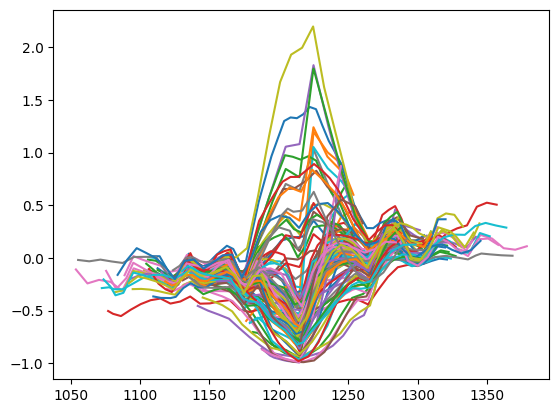

In [178]:
i=0
equiv_widths = []
lyalphas = []
redshifts = []
specs = []
em1s = []
em2s = []
continuums = []


while(i < 100):
    
    sps.update_model(sps_model, sps_parameters[i], z_history=False, agebins=sfh.default_agebins())
    spectrum_data = sps.fsps_get_sed(sps_model)
    wave = spectrum_data[0]
    sed = sps.redshift_fsps_spectrum(sps_model, spectrum_data)
    redshift = sps_model.params['zred']
    redshifts.append(redshift)



    dlambda = 200
    lyalpha = 1215.16*(1+redshift)
    lyalphas.append(lyalpha)

    l1 = lyalpha - dlambda
    l2 = lyalpha + dlambda

    indx1 = np.where(wave>l1)[0]
    indx2 = np.where(wave<l2)[0]
    indx = np.intersect1d(indx1, indx2)

    em1 = np.interp(l1, wave[indx], sed[indx])
    em2 = np.interp(l2, wave[indx], sed[indx])

    continuum_level = (em2-em1)/(l2-l1)*(lyalpha-l1) + em1
    continuums.append(continuum_level)


    area = np.trapz(sed[indx] - continuum_level, wave[indx])
    equiv_width = area/continuum_level
    equiv_widths.append(equiv_width)
    specs.append((wave, sed))
    plt.plot(wave[indx]/(1+redshift), ((sed[indx]-continuum_level)/area)*equiv_width)

    #em1s.append((em1-continuum_level)/(lyalpha-continuum_level))
    #em2s.append((em2-continuum_level)/(lyalpha-continuum_level))

    em1s.append(em1)
    em2s.append(em2)

    i+=1

equiv_widths = np.array(equiv_widths)
em1s = np.array(em1s)
em2s = np.array(em2s)
continuums = np.array(continuums)
lyalphas = np.array(lyalphas)
#plt.yscale('log')

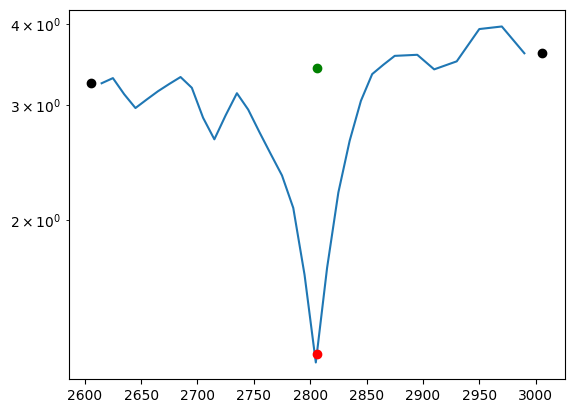

In [301]:
j = np.random.randint(0, 100)
wave, sed = specs[j]
lyalpha = lyalphas[j]
em1 = em1s[j]
em2 = em2s[j]
continuum_level = continuums[j]
redshift = redshifts[j]

l1 = lyalpha - dlambda
l2 = lyalpha + dlambda
indx1 = np.where(wave>lyalpha-dlambda)[0]
indx2 = np.where(wave<lyalpha+dlambda)[0]
indx = np.intersect1d(indx1, indx2)



plt.plot(wave[indx], sed[indx])
plt.plot(lyalpha,np.interp(lyalpha, wave, sed),'ro') 
plt.plot(l1,em1,'ko') 
plt.plot(lyalpha,continuum_level,'go')
plt.plot(l2,em2,'ko') 

plt.yscale('log')

(array([ 3.,  4.,  2.,  4.,  9.,  7., 13., 16., 16.,  8.,  5.,  2.,  2.,
         3.,  1.,  0.,  1.,  1.,  1.,  2.]),
 array([-246.63421433, -220.55760124, -194.48098815, -168.40437506,
        -142.32776197, -116.25114888,  -90.17453578,  -64.09792269,
         -38.0213096 ,  -11.94469651,   14.13191658,   40.20852967,
          66.28514277,   92.36175586,  118.43836895,  144.51498204,
         170.59159513,  196.66820822,  222.74482132,  248.82143441,
         274.8980475 ]),
 <BarContainer object of 20 artists>)

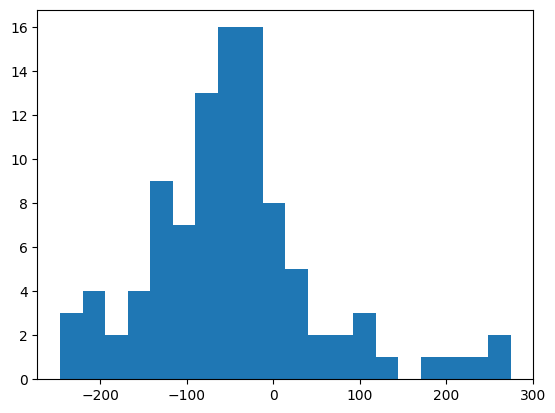

In [180]:
plt.hist(equiv_widths, bins=20)

10252.657074003208 48745.083808175834


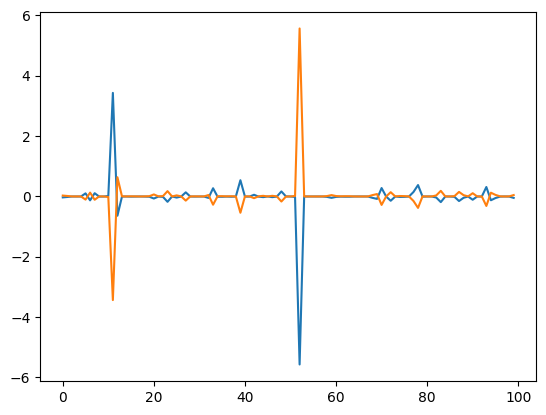

In [194]:
plt.plot((em1s - continuums)/(lyalphas - continuums))
print(np.mean(em1s), np.std(em1s))
plt.plot((em2s - continuums)/(lyalphas - continuums))

-38.379045654787284


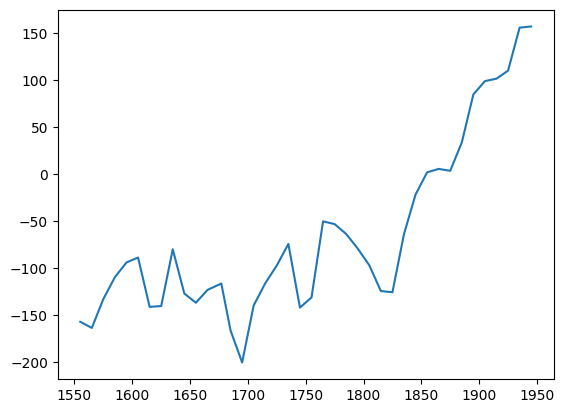

In [9]:
sps.update_model(sps_model, sps_parameters[np.random.randint(0, ngalaxies)], z_history=False, agebins=sfh.default_agebins())
spectrum_data = sps.fsps_get_sed(sps_model)
wave = spectrum_data[0]
sed = sps.redshift_fsps_spectrum(sps_model, spectrum_data)
redshift = sps_model.params['zred']
redshifts.append(redshift)

dlambda = 200
lyalpha = 1215.16*(1+redshift)

l1 = lyalpha - dlambda
l2 = lyalpha + dlambda

indx1 = np.where(wave>l1)[0]
indx2 = np.where(wave<l2)[0]
indx = np.intersect1d(indx1, indx2)

em1 = np.interp(l1, wave[indx], sed[indx])
em2 = np.interp(l2, wave[indx], sed[indx])

continuum_level = (em2-em1)/(l2-l1)*(lyalpha-l1) + em1


area = np.trapz(sed[indx] - continuum_level, wave[indx])
equiv_width = area/continuum_level
print(equiv_width)

plt.plot(wave[indx], sed[indx] - continuum_level)


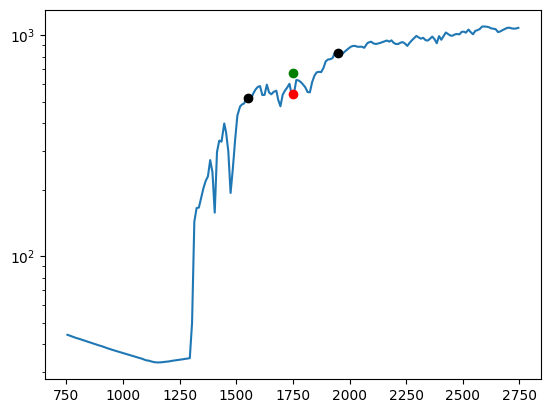

In [10]:
indx1 = np.where(wave>lyalpha-1000)[0]
indx2 = np.where(wave<lyalpha+1000)[0]
indx = np.intersect1d(indx1, indx2)



plt.plot(wave[indx], sed[indx])
plt.plot(lyalpha,np.interp(lyalpha, wave, sed),'ro') 
plt.plot(l1,em1,'ko') 
plt.plot(lyalpha,continuum_level,'go')
plt.plot(l2,em2,'ko') 

plt.yscale('log')